In [19]:
import sys
import os
import string
import re
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import importlib
sys.path.append(os.path.abspath(".."))
import scripts.preprocess as preprocess
importlib.reload(preprocess)

# Ajoute la racine du projet au path (celle qui contient 'scripts')



<module 'scripts.preprocess' from 'c:\\Users\\user\\Documents\\cours MDV P2025.2\\data\\cour 4\\ml-production-template\\scripts\\preprocess.py'>

In [20]:
cfg = preprocess.load_config()

# Utilise le répertoire courant du notebook
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # <- notebook = ./notebooks
db_path = os.path.join(root_dir, "data/raw", "data.db")

# Connexion à SQLite
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Lecture des données
cursor.execute("SELECT * FROM annotation")
rows = cursor.fetchall()
df = pd.DataFrame(rows, columns=[column[0] for column in cursor.description])

print(df.head())


c:\Users\user\Documents\cours MDV P2025.2\data\cour 4\ml-production-template
   id  ANNOTATION_NUMBER                                             ACTION  \
0   1             100001  TRIED TO ADJUST IDLE SEVERAL TIMES, WOULDN'T A...   
1   2             100002                      REMOVED & REPLACED FUEL SERVO   
2   3             100003  A/C WAS RUN UP, SET IDLE SPEED, MIXTURE OK, NO...   
3   4             100004  PERFORMED ENGINE RUN UP, FOUND CYL 2 LOWER PLU...   
4   5             100005                        REMOVED & REPLACED GASKETS.   

                                             PROBLEM  
0                ENGINE IDLE OVERRIDE KILLED ENGINE.  
1                ENGINE IDLE OVERRIDE KILLED ENGINE.  
2                ENGINE IDLE OVERRIDE KILLED ENGINE.  
3  HAD ENGINE CHOKE & BRIEFLY LOSE POWER ON DEPAR...  
4       #2 & 4 CYL ROCKER COVER GASKETS ARE LEAKING.  


# 2 nettoyage
# 2.1 ACTION


In [21]:
print(df["ACTION"].value_counts())
print(df["ACTION"].describe)

ACTION
REMOVED & REPLACED GASKET.                                 450
REMOVED & REPLACED GASKETS.                                249
REMOVED & REPLACED INTAKE GASKET.                          228
REPLACED GASKET.                                           219
REMOVED & REPLACED ROCKER COVER GASKETS.                   164
REMOVED & REPLACED ROCKER COVER GASKET.                    152
REMOVED & REPLACED INTAKE GASKETS.                         148
STOP DRILLED CRACK.                                        147
REPLACED GASKETS.                                           67
LEAK CK GOOD.                                               57
REMOVED & REPLACED #2 INTAKE GASKET.                        49
INSTALLED NEW SCREW.                                        47
REMOVED & REPLACED GASKET W/ NEW.                           45
REPLACED INTAKE GASKET.                                     37
REMOVED & REPLACED W/ NEW GASKET.                           34
REMOVED & REPLACED #2 ROCKER COVER GASKET.      

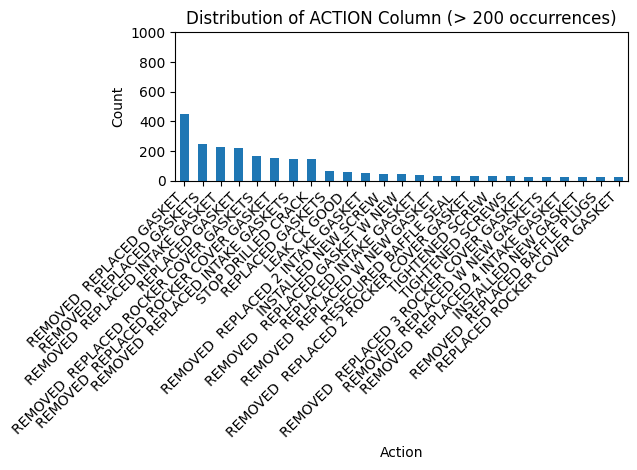

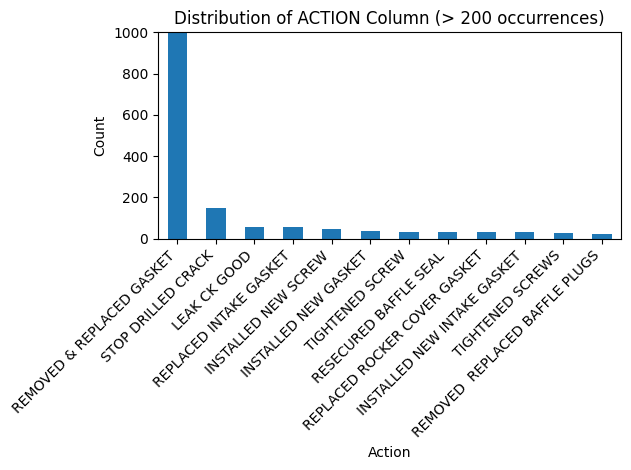

In [22]:
# 2) Nettoyage

# 2.1 )nettoyage mannuel
df_cleaning = df.copy()
# punct_to_remove = string.punctuation.replace("&", "")
# punct_to_remove = string.punctuation.replace("#", "")

df_cleaning["ACTION"] = df_cleaning["ACTION"].str.replace(f"[{string.punctuation}]", "", regex=True)

preprocess.show_histo(df_cleaning,"ACTION")

df_cleaning["ACTION"] = df_cleaning["ACTION"].str.replace(
    "GASKETS", 
    "GASKET",
    case=False,
    regex=False
)

df_cleaning["ACTION"] = df_cleaning["ACTION"].str.replace(
    r"(?i)^removed\s*replaced.*gaskets?.*$",
    "REMOVED & REPLACED GASKET",
    regex=True
)

df_cleaning.loc[
    df_cleaning["ACTION"].str.strip().str.upper() == "REPLACED GASKET",
    "ACTION"
] = "REMOVED & REPLACED GASKET"

preprocess.show_histo(df_cleaning,"ACTION")




# 2.2 PROBLEM

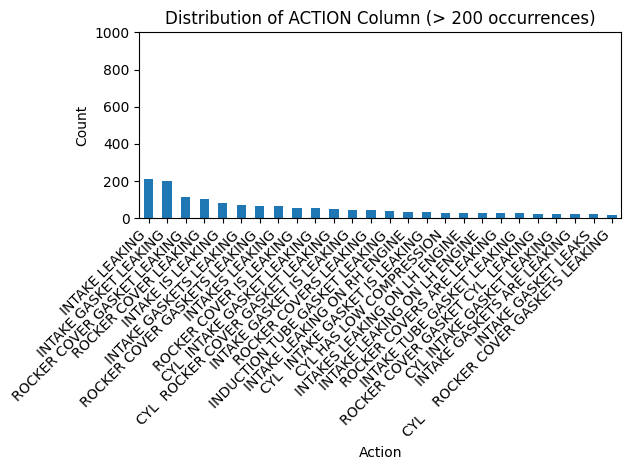

In [23]:
df_cleaning["PROBLEM"] = df_cleaning["PROBLEM"].str.replace(f"[{string.punctuation}0-9]", "", regex=True)
df_cleaning["PROBLEM"] = df_cleaning["PROBLEM"].str.strip()
preprocess.show_histo(df_cleaning,"PROBLEM")

#df_cleaning["PROBLEM"] = df_cleaning["PROBLEM"].apply(preprocess.remove_stopwords)

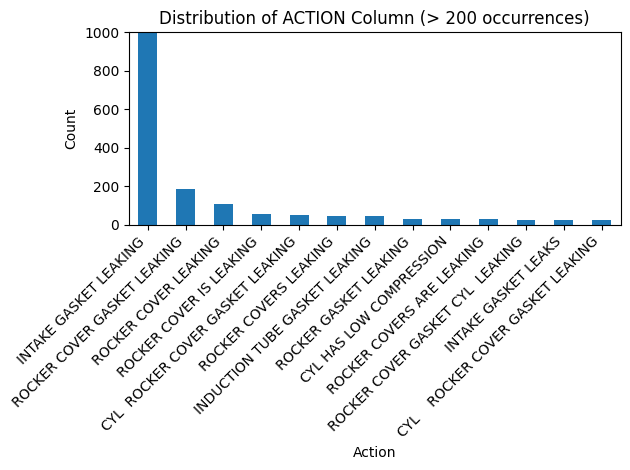

In [24]:
df_cleaning["PROBLEM"] = df_cleaning["PROBLEM"].str.replace(
    "GASKETS", 
    "GASKET",
    case=False,
    regex=False
)

df_cleaning["PROBLEM"] = df_cleaning["PROBLEM"].str.replace(
    "INTAKE LEAKING",
    "INTAKE GASKET LEAKING",
    regex=True
)

df_cleaning.loc[
    df_cleaning["PROBLEM"].str.contains(r"(?i)intake.*leaking", regex=True),
    "PROBLEM"
] = "INTAKE GASKET LEAKING"

preprocess.show_histo(df_cleaning,"PROBLEM")



In [25]:
df_cleaned = df_cleaning.copy()


# Vectorisation de action et problem

In [26]:
output_embbeding_action_file = os.path.join(root_dir, "data/preprocessed", "embeddings_action.csv")
output_embbeding_problem_file = os.path.join(root_dir, "data/preprocessed", "embeddings_problem.csv")
if os.path.exists(output_embbeding_action_file) is not True:
    text_pipe = preprocess.build_text_pipeline(cfg)
    SPCY_action_vectorised_df = text_pipe.fit_transform(df_cleaned["ACTION"])
    feature_names = text_pipe.named_steps["vectorizer"].get_feature_names_out()
    df_tfidf_action = pd.DataFrame(SPCY_action_vectorised_df.toarray(), columns=feature_names)
    df_tfidf_action.to_csv(output_embbeding_action_file, index=False)
else:
    SPCY_action_vectorised_df = pd.read_csv(output_embbeding_action_file)

if os.path.exists(output_embbeding_problem_file) is not True:
    text_pipe = preprocess.build_text_pipeline(cfg)
    SPCY_problem_vectorised_df = text_pipe.fit_transform(df_cleaned["PROBLEM"])
    feature_names = text_pipe.named_steps["vectorizer"].get_feature_names_out()
    df_tfidf_problem = pd.DataFrame(SPCY_problem_vectorised_df.toarray(), columns=feature_names)
    df_tfidf_problem.to_csv(output_embbeding_problem_file, index=False)
else:
    SPCY_problem_vectorised_df = pd.read_csv(output_embbeding_problem_file)


# 3 Visualisation des modèles
## 3.1 Action

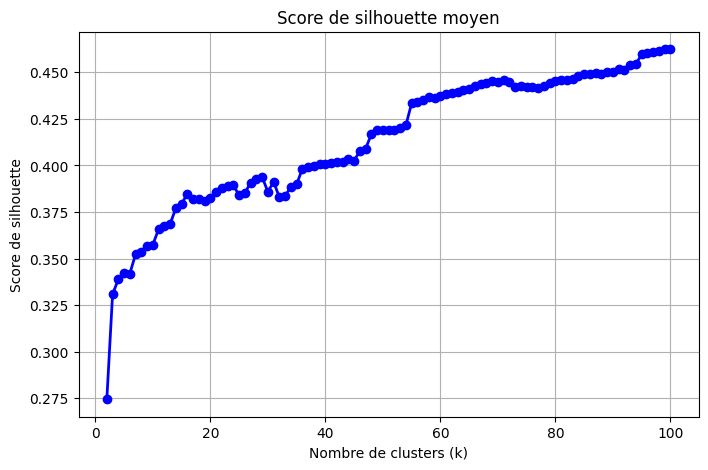

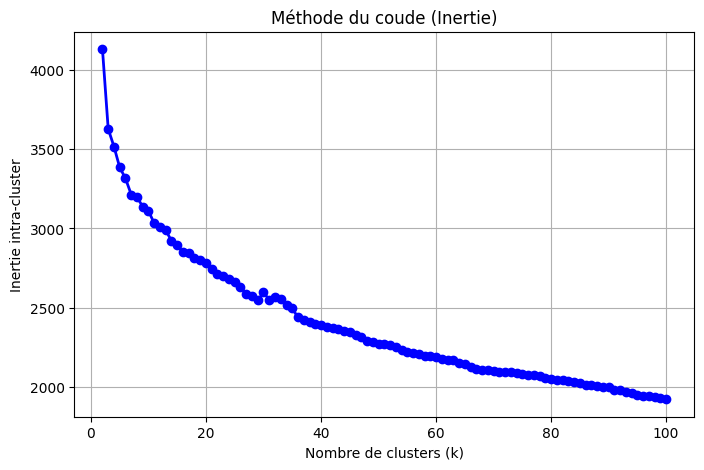

In [27]:

# visualisation 
preprocess.plot_elbow(SPCY_action_vectorised_df, metric="silhouette") # mieux pour nlp
preprocess.plot_elbow(SPCY_action_vectorised_df)

## 3.2 Problem

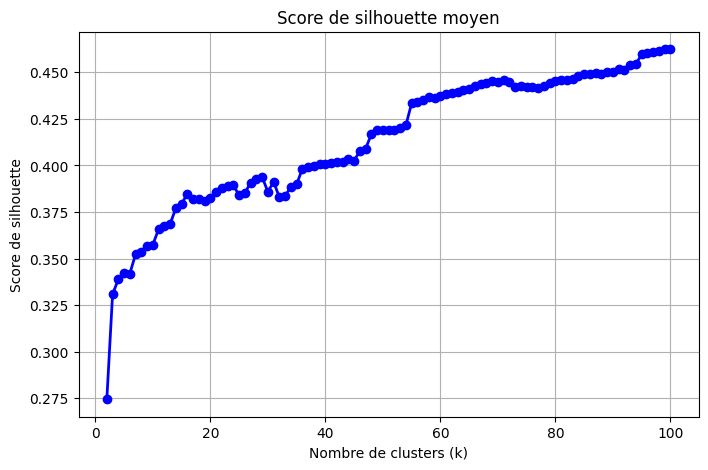

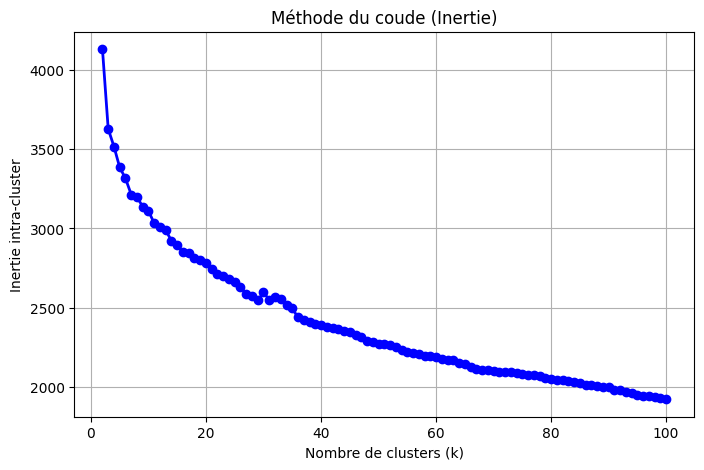

In [28]:
preprocess.plot_elbow(SPCY_problem_vectorised_df, metric="silhouette") # mieux pour nlp
preprocess.plot_elbow(SPCY_problem_vectorised_df)

# 4 Clustering 
Action = 92 cluster

Problem = 72 cluster


In [29]:
df_92_78_k = df_cleaned.copy()
df_92_78_k["ACTION_CLUSTER"] = preprocess.clustering(SPCY_action_vectorised_df,n_clusters=92)
df_92_78_k["PROBLEM_CLUSTER"] = preprocess.clustering(SPCY_problem_vectorised_df,n_clusters=78)

In [30]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df_92_78_k[df_92_78_k["ACTION_CLUSTER"].isin([91])][["ACTION", "ACTION_CLUSTER"]])


                                                 ACTION  ACTION_CLUSTER
279           STOP DRILLED CRACK IN RH ENG 3 AFT BAFFLE              91
337                               RESECURED BAFFLE SEAL              91
521                FABRICATED PATCH FROM LIKE MATERIAL               91
784   REMOVED RH AFT ENG BAFFLE STOP DRILLED CRACK F...              91
871   INSPECTED  FOUND CRACK TO HAVE BEEN PREVIOUSLY...              91
1192                                 STOP DRILLED CRACK              91
1384                                 STOP DRILLED CRACK              91
1705                                 STOP DRILLED CRACK              91
1774                                 STOP DRILLED CRACK              91
1794  DISCONNECTED OIL PRESSURE LINE DISPLACED OIL C...              91
1916  REMOVED BAFFLE DRILLED OUT RIVETS  REMOVED CRA...              91
2062  REPOSITIONED LEFT BAFFLE TO CLEAR FROM ENGINE ...              91
2213  REMOVED OIL DIPSTICK INSTALLED BAFFLE SCREW RE...         

In [31]:
print(df_92_78_k[df_92_78_k["PROBLEM_CLUSTER"].isin([54])][["PROBLEM", "PROBLEM_CLUSTER"]])

                                                PROBLEM  PROBLEM_CLUSTER
461                 LH BAFFLE PLUG NEEDS TO BE REPLACED               54
766                     OIL COOLER NEEDS TO BE REPLACED               54
1144                LH BAFFLE PLUG NEEDS TO BE REPLACED               54
1297                RH BAFFLE PLUG NEEDS TO BE REPLACED               54
1596      CYL  ROCKER COVER GASKET NEEDS TO BE REPLACED               54
1624                RH BAFFLE PLUG NEEDS TO BE REPLACED               54
2136                  BAFFLE PLUGS NEEDS TO BE REPLACED               54
2980         LH BAFFLE BUTTON PLUG NEEDS TO BE REPLACED               54
3132                   CHT FITTING NEEDS TO BE REPLACED               54
3384                       ENGINE NEEDS TO BE PRESERVED               54
3385                       ENGINE NEEDS TO BE PRESERVED               54
3386                       ENGINE NEEDS TO BE PRESERVED               54
3387                       ENGINE NEEDS TO BE PRESE

# Entrainement du model

In [32]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

y = df_92_78_k["ACTION_CLUSTER"]

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df_92_78_k["PROBLEM"])

model = RandomForestClassifier()
model.fit(X, y)


new_problems = ["ENGINE NEEDS TO BE PRESERVED.", 
               "RIGHT BAFFLE PLUG DAMAGED.", 
               "#1, 2, 4 INTAKE GASKETS LEAKING.", 
               "BAFFLE PLUG ABOVE #4 CYL HAS BROKEN TABS."]
X_new = vectorizer.transform(new_problems)

y_pred = model.predict(X_new)
print(y_pred)


[54 56  1 87]


# Etude du model

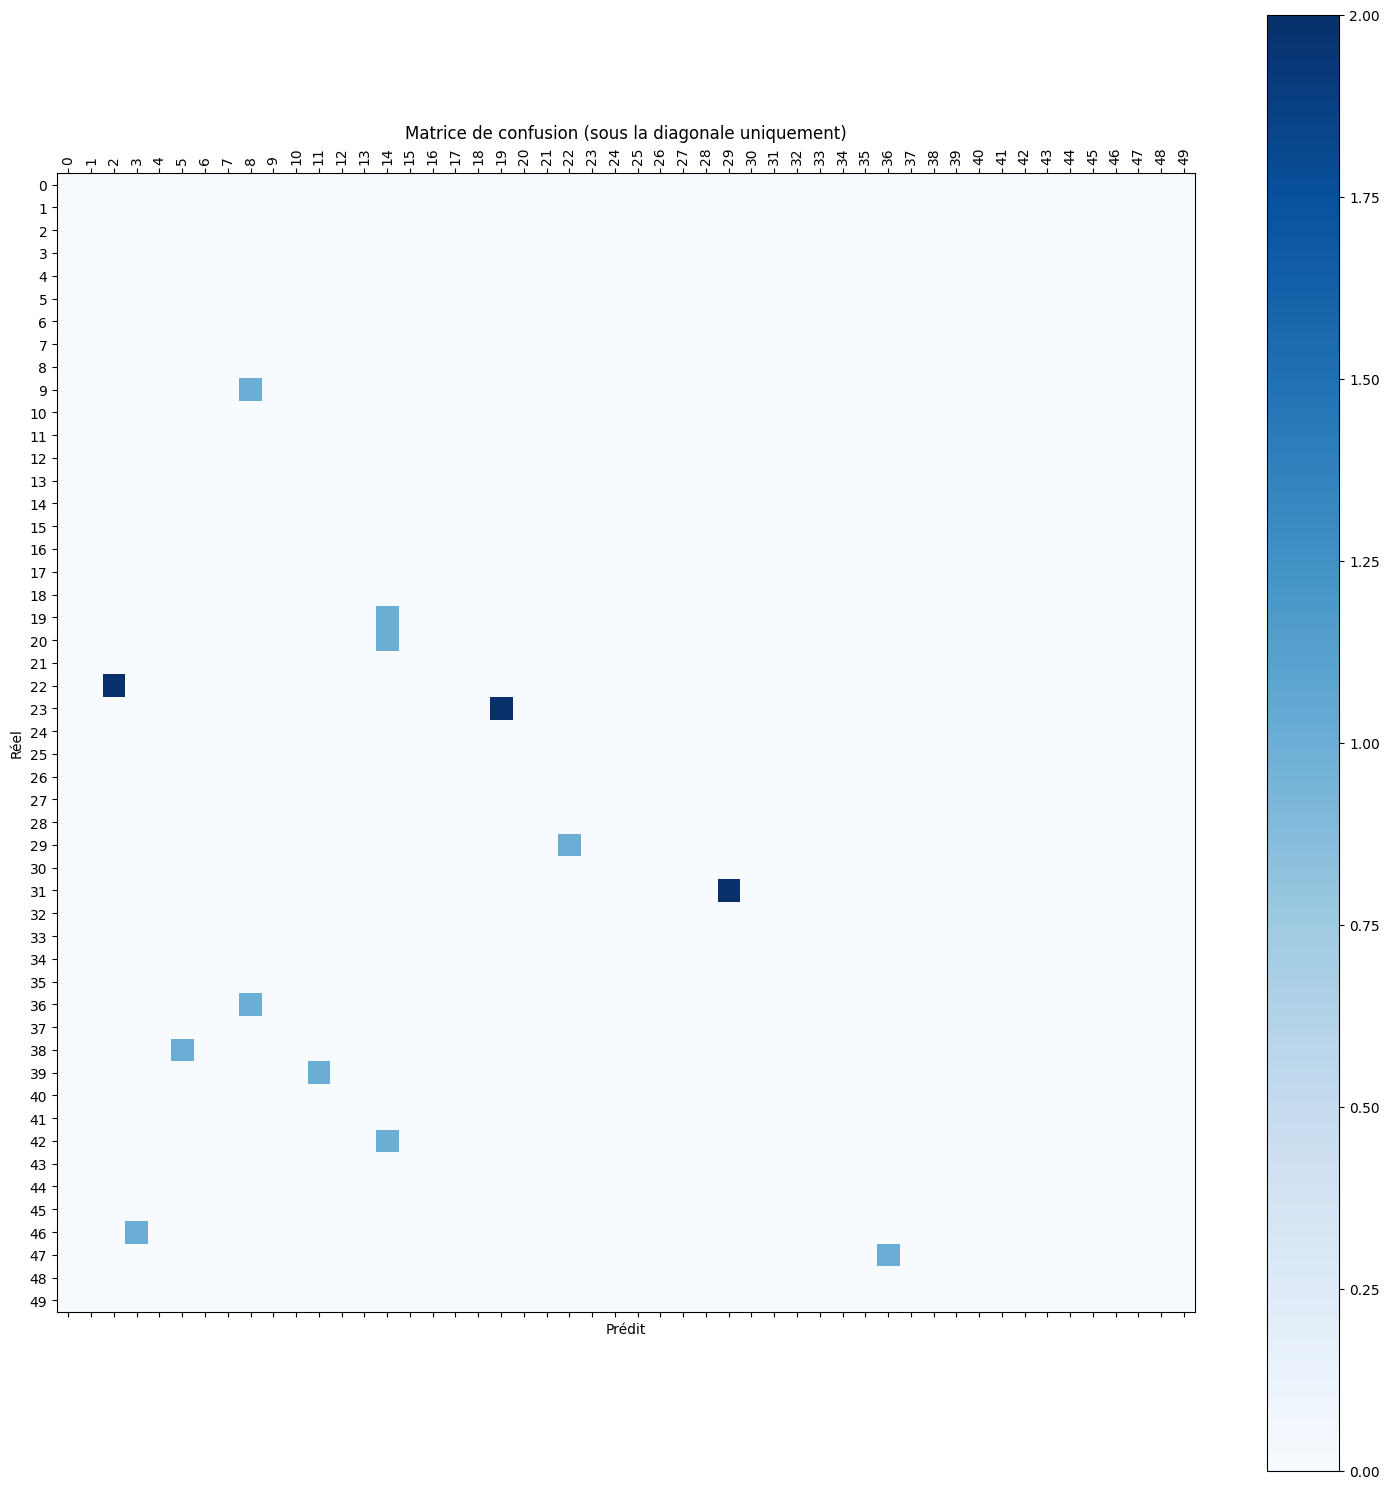

In [33]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

labels_used = sorted(set(y_test) | set(y_pred))
class_names = labels_used


max_labels = 50
cm_small = cm[:max_labels, :max_labels]
class_names_small = class_names[:max_labels]

# Supprimer les éléments au-dessus de la diagonale
mask = np.tril(np.ones_like(cm_small, dtype=bool), k=-1)  # sous la diagonale (k=-1)
cm_masked = np.where(mask, cm_small, 0)

# Affichage manuel
fig, ax = plt.subplots(figsize=(15, 15))
cax = ax.matshow(cm_masked, cmap="Blues")
plt.colorbar(cax)

# Ticks et labels
ax.set_xticks(range(len(class_names_small)))
ax.set_yticks(range(len(class_names_small)))
ax.set_xticklabels(class_names_small, rotation=90)
ax.set_yticklabels(class_names_small)

plt.title("Matrice de confusion (sous la diagonale uniquement)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

In [34]:


# Générer le rapport sous forme de dictionnaire
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Transformer en DataFrame
report_df = pd.DataFrame(report_dict).T

# Supprimer les lignes globales ('accuracy', 'macro avg', etc.)
report_df = report_df.drop(["accuracy", "macro avg", "weighted avg"])

# Convertir l’index en entier pour trier si nécessaire
report_df.index = report_df.index.astype(int)
worst_clusters = report_df.sort_values("f1-score").head(10)
print(worst_clusters)

    precision    recall  f1-score  support
91   0.500000  0.200000  0.285714      5.0
8    0.500000  0.400000  0.444444      5.0
52   0.666667  0.400000  0.500000     10.0
42   1.000000  0.400000  0.571429     10.0
14   0.529412  0.818182  0.642857     11.0
71   0.500000  1.000000  0.666667      1.0
67   0.500000  1.000000  0.666667      3.0
82   1.000000  0.500000  0.666667      2.0
69   0.642857  0.750000  0.692308     12.0
37   0.666667  0.800000  0.727273     10.0


In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00       355
           2       0.95      0.98      0.96        55
           3       0.62      1.00      0.77         5
           4       1.00      1.00      1.00        12
           5       0.80      1.00      0.89         4
           6       1.00      0.90      0.95        10
           7       0.88      1.00      0.93        14
           8       0.50      0.40      0.44         5
           9       1.00      0.83      0.91         6
          10       1.00      0.78      0.88         9
          11       0.83      1.00      0.91        20
          12       1.00      0.69      0.82        13
          13       1.00      0.86      0.92         7
          14       0.53      0.82      0.64        11
          15       1.00      0.75      0.86         4
          16       1.00      1.00      1.00         3
          17       1.00    

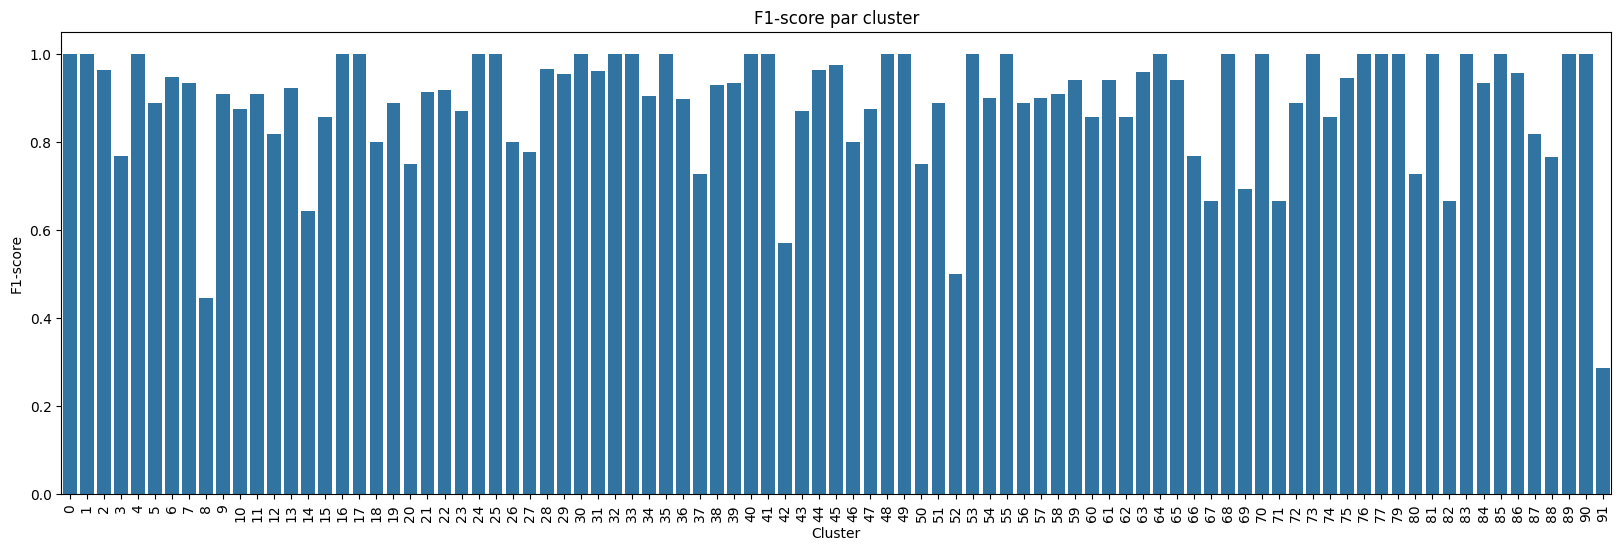

In [35]:

plt.figure(figsize=(20, 6))
sns.barplot(x=report_df.index, y=report_df["f1-score"])
plt.title("F1-score par cluster")
plt.xlabel("Cluster")
plt.ylabel("F1-score")
plt.xticks(rotation=90)
plt.show()